## Vehicle Detection and Tracking

In [1]:
# Import modules
import pickle
import cv2
import numpy as np
# import matplotlib
# matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import random
import time
from PIL import Image, ImageDraw
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# Read in camera calibration data
calib_cam = pickle.load( open( "calib_cam.p", "rb" ) )
mtx = calib_cam['mtx']
dist = calib_cam['dist']

In [3]:
# Read in image data
v_path = 'vehicles/'
nv_path = 'non-vehicles/'

v_data = []
for root, dirs, files in os.walk(v_path):
    for name in files:
        if name.endswith('.png'):
            img_dir = os.path.join(root, name)
            img = mpimg.imread(img_dir)
            img2 = np.fliplr(img)
            v_data.append(img)
            v_data.append(img2)

nv_data = []
for root, dirs, files in os.walk(nv_path):
    for name in files:
        if name.endswith('.png'):
            img_dir = os.path.join(root, name)
            img = mpimg.imread(img_dir)
            img2 = np.fliplr(img)
            nv_data.append(img)
            nv_data.append(img2)
            
data = {'vehicles': v_data, 'non-vehicles': nv_data}
with open('data.p', 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
data = pickle.load( open( "data.p", "rb" ) )
v_data = data['vehicles']
nv_data = data['non-vehicles']

print(len(v_data), len(nv_data))

17584 17936


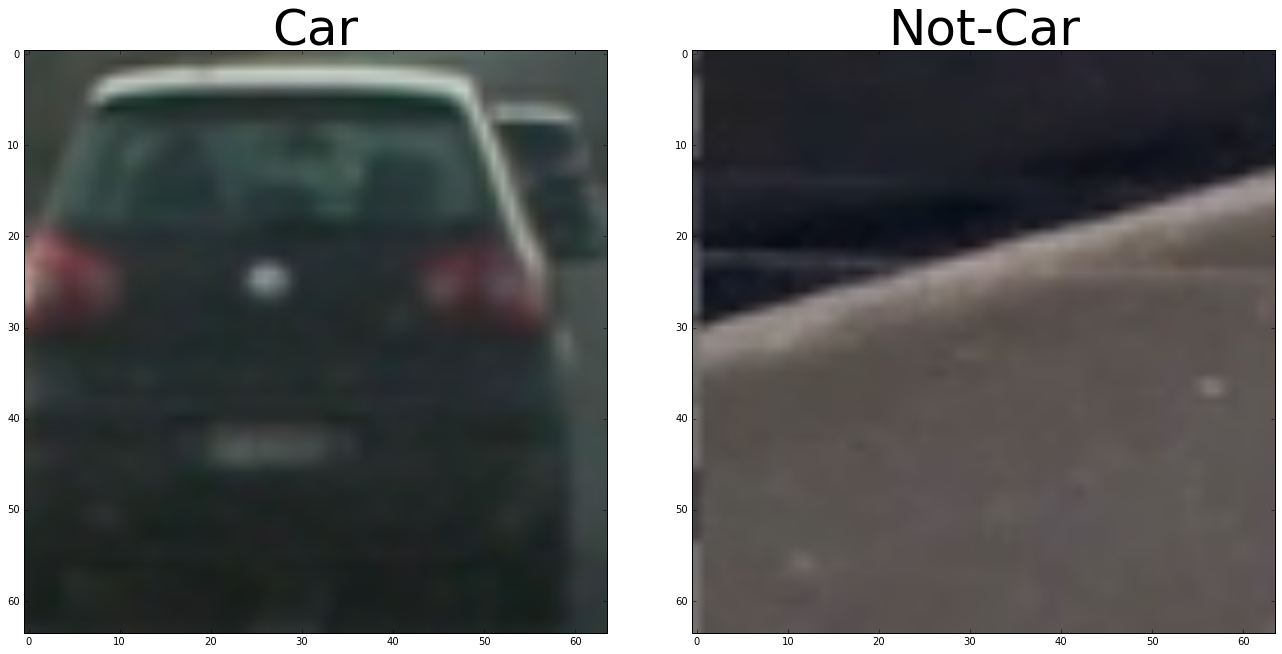

In [89]:
# Random Visualization
v_idx = random.randint(0, len(v_data) - 1)
nv_idx = random.randint(0, len(nv_data) - 1)
test_v = v_data[v_idx]
test_nv = nv_data[nv_idx]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
f.tight_layout()
ax1.imshow(test_v)
ax1.set_title('Car', fontsize=50)
ax2.imshow(test_nv)
ax2.set_title('Not-Car', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/example_images.png")

In [333]:
# Convert color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb) / 255.0
    if conv == 'BRG2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb) / 255.0
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV) / 255.0
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV) / 255.0

    
# Extract HOG features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis == True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                 cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Extract color features 
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Extract color histogram features
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

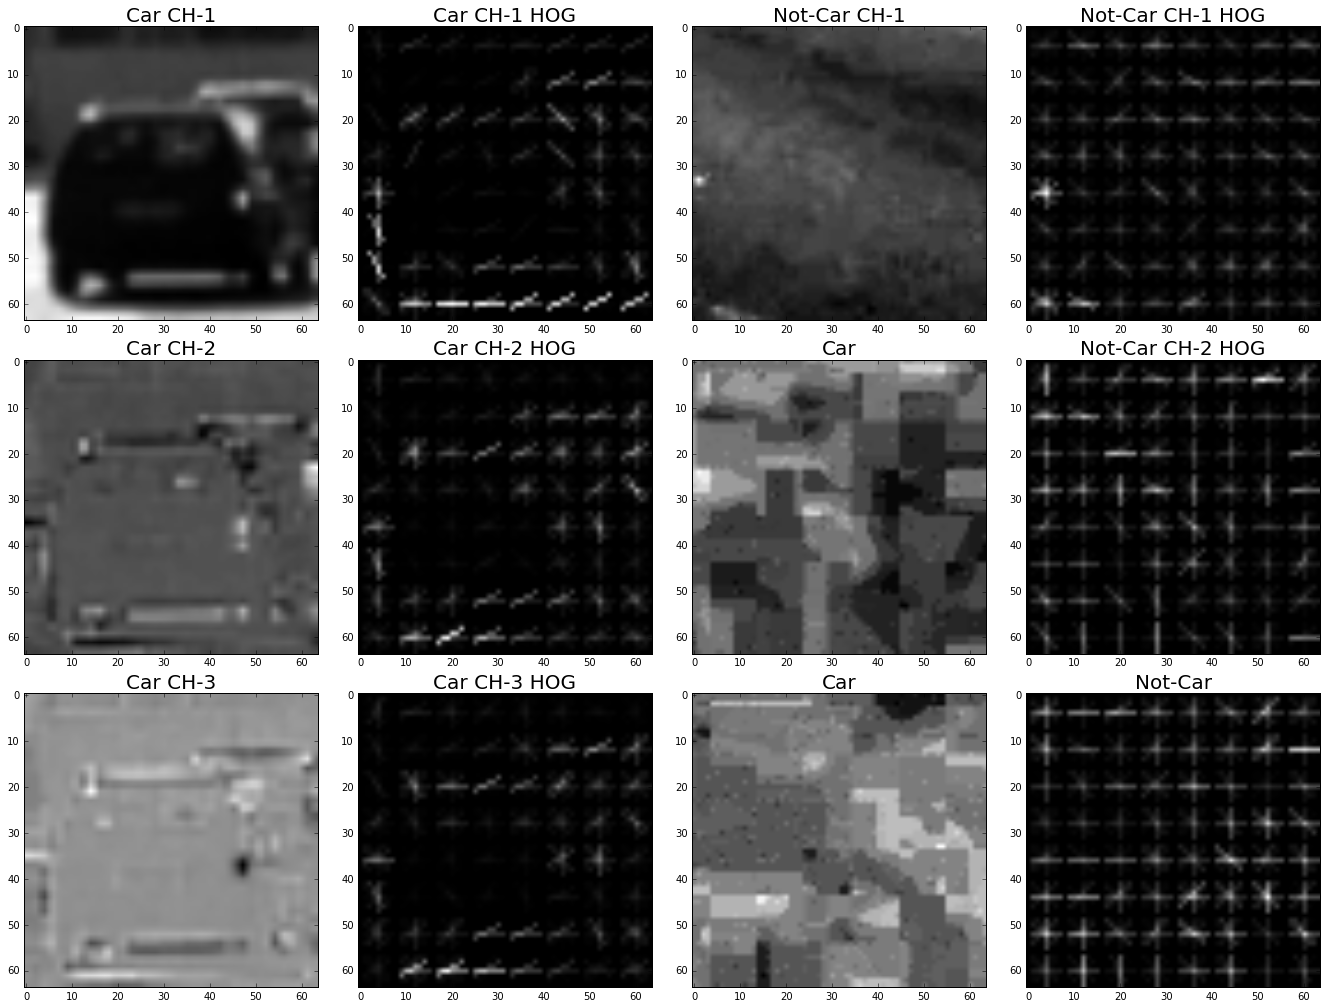

In [91]:
# Random Visualization
v_idx = random.randint(0, len(v_data) - 1)
nv_idx = random.randint(0, len(nv_data) - 1)
test_v = v_data[v_idx]
test_nv = nv_data[nv_idx]

test_v_cs = convert_color(test_v, conv='RGB2YCrCb')
ft1_v, hog1_v = get_hog_features(test_v_cs[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
ft2_v, hog2_v = get_hog_features(test_v_cs[:,:,1], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
ft3_v, hog3_v = get_hog_features(test_v_cs[:,:,2], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

test_nv_cs = convert_color(test_nv, conv='RGB2YCrCb')
ft1_nv, hog1_nv = get_hog_features(test_nv_cs[:,:,0], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
ft2_nv, hog2_nv = get_hog_features(test_nv_cs[:,:,1], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
ft3_nv, hog3_nv = get_hog_features(test_nv_cs[:,:,2], orient=8, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(18, 15))
f.tight_layout()

ax1.imshow(test_v_cs[:,:,0], cmap='gray')
ax1.set_title('Car CH-1', fontsize=20)
ax2.imshow(hog1_v, cmap='gray')
ax2.set_title('Car CH-1 HOG', fontsize=20)
ax3.imshow(test_nv_cs[:,:,0], cmap='gray')
ax3.set_title('Not-Car CH-1', fontsize=20)
ax4.imshow(hog1_nv, cmap='gray')
ax4.set_title('Not-Car CH-1 HOG', fontsize=20)

ax5.imshow(test_v_cs[:,:,1], cmap='gray')
ax5.set_title('Car CH-2', fontsize=20)
ax6.imshow(hog2_v, cmap='gray')
ax6.set_title('Car CH-2 HOG', fontsize=20)
ax7.imshow(test_nv_cs[:,:,1], cmap='gray')
ax7.set_title('Not-Car CH-2', fontsize=20)
ax8.imshow(hog2_nv, cmap='gray')
ax8.set_title('Not-Car CH-2 HOG', fontsize=20)

ax9.imshow(test_v_cs[:,:,2], cmap='gray')
ax9.set_title('Car CH-3', fontsize=20)
ax10.imshow(hog3_v, cmap='gray')
ax10.set_title('Car CH-3 HOG', fontsize=20)
ax11.imshow(test_nv_cs[:,:,2], cmap='gray')
ax11.set_title('Not-Car CH-3', fontsize=20)
ax12.imshow(hog3_nv, cmap='gray')
ax12.set_title('Not-Car CH-3 HOG', fontsize=20)

# ax13.imshow(test_v_ycc[:,:,2], cmap='gray')
# ax13.set_title('Car CH-3', fontsize=20)
# ax14.imshow(ft3_v)
# ax14.set_title('Not-Car', fontsize=20)
# ax15.imshow(test_v)
# ax15.set_title('Car', fontsize=20)
# ax16.imshow(test_nv)
# ax16.set_title('Not-Car', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/example_hogs.png")

In [334]:
# Classification Pipeline
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_featuresHOG(imgs, cspace='RGB2YCrCb', orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=cspace)    

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_featuresColor(imgs, cspace='RGB2YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, conv=cspace)   
     
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

In [335]:
# CLAHE
def clahe(imgs):
    imgs_cl = []
    for image in imgs:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.uint8)

        clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(3,3))
        cl = clahe.apply(hsv[:,:,2])

        img_cl = cv2.merge([hsv[:,:,0], hsv[:,:,1], cl])
        img_cl = (cv2.cvtColor(img_cl, cv2.COLOR_HSV2RGB) / 255.0).astype(np.float32)
        imgs_cl.append(img_cl)

    return imgs, imgs_cl

In [414]:
# Divide up into cars and notcars
cars = v_data
notcars = nv_data

# Reduce the sample size because HOG features are slow to compute
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# Tweak these parameters and see how the results change.
colorspace = 'RGB2YCrCb' # Can be RGB2HSV, RGB2LUV, RGB2HLS, RGB2YCrCb, BGR2CrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# _, cars_cl = clahe(cars)
# _, notcars_cl = clahe(notcars)

t=time.time()
car_spatial_features = []
car_hist_features = []
for car in cars:
    car_spatial_features.append(bin_spatial(car))
    car_hist_features.append(color_hist(car))
car_hog_features = extract_featuresHOG(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_spatial_features = []
notcar_hist_features = []
for notcar in notcars:
    notcar_spatial_features.append(bin_spatial(notcar))
    notcar_hist_features.append(color_hist(notcar))
notcar_hog_features = extract_featuresHOG(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

car_features = np.hstack((car_spatial_features, car_hist_features, car_hog_features))
notcar_features = np.hstack((notcar_spatial_features, notcar_hist_features, notcar_hog_features))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

280.15 Seconds to extract features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9048
99.01 Seconds to train SVC...
Test Accuracy of SVC =  0.9911
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  1.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  1.  1.  0.]
0.05483 Seconds to predict 10 labels with SVC


In [415]:
svm = {'svc': svc}
with open('svm.p', 'wb') as f:
    pickle.dump(svm, f, protocol=pickle.HIGHEST_PROTOCOL)

In [416]:
# Detection Pipeline
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, isDrawBoxes=False):
    
    draw_img = np.copy(img)
    # matplotlib image will read .jpg images in on a scale of 0 to 255, .png on a scale of 0 to 1
    img = img.astype(np.float32)/255 
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
        
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
     
    if isDrawBoxes == True:
        return bbox_list, draw_img
        
    return bbox_list

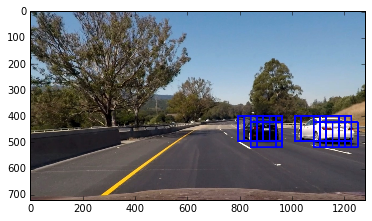

In [417]:
test_images = glob.glob('test_images/*.jpg')
img = mpimg.imread(test_images[5])
# Undistortion
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

ystart = 400 
ystop = 656
xstart = 0
xstop = 1280
scale = 1.5
spatial_size = (32, 32)
hist_bins = 32

box_list, out_img = find_cars(img_undist, ystart, ystop, xstart, xstop, scale, svc, X_scaler, 
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)
plt.imshow(out_img)
plt.savefig('output_images/out_img.png')

In [690]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
    # return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return threshold map
    return heatmap


def resize_bbox(bbox):
    cx = (bbox[1][0] + bbox[0][0]) / 2 
    if 980 < cx <= 1280 or 0 <= cx < 300:
        factor = 1.6
    elif 780 < cx <= 980 or 300 <= cx < 500:
        factor = 1.3
    else:
        factor = 1
        
    offset = int(((bbox[1][1] - bbox[0][1]) * factor - (bbox[1][0] - bbox[0][0])) / 2)
    draw_bbox = [list(i) for i in bbox]
    draw_bbox[0][0] -= offset
    draw_bbox[1][0] += offset
    draw_bbox = tuple(tuple(i) for i in draw_bbox)
    
    return draw_bbox
       

def lpf(bbox, prev_bbox, alpha=0.75):
    bbox_list = [list(i) for i in bbox]
    prev_bbox_list = [list(j) for j in prev_bbox]
    
    new_bbox = np.copy(bbox_list)
    new_bbox[0][0] = alpha * bbox_list[0][0] + (1 - alpha) * prev_bbox_list[0][0]
    new_bbox[0][1] = alpha * bbox_list[0][1] + (1 - alpha) * prev_bbox_list[0][1]
    new_bbox[1][0] = alpha * bbox_list[1][0] + (1 - alpha) * prev_bbox_list[1][0]
    new_bbox[1][1] = alpha * bbox_list[1][1] + (1 - alpha) * prev_bbox_list[1][1]
    new_bbox = tuple(tuple(k) for k in new_bbox)
    
    return new_bbox
    
    
def draw_labeled_bboxes(img, labels, prev_labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#         bbox = resize_bbox(bbox)

#         # Smooth the box
#         if len(labels) == len(prev_labels):
#             nonzero = (prev_labels[0] == car_number).nonzero()
#             nonzeroy = np.array(nonzero[0])
#             nonzerox = np.array(nonzero[1])
#             if len(nonzerox) > 0 and len(nonzeroy) > 0:
#                 prev_bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#                 bbox = lpf(bbox, prev_bbox)

        # Draw the box on the image
        if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) >= 5000:
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 4)
    # Return the image
    return img

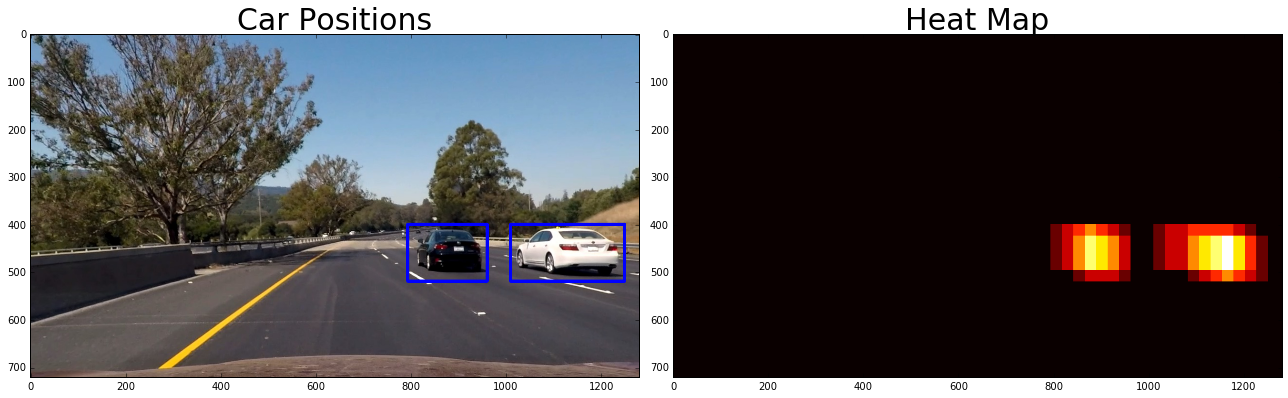

In [683]:
heat = np.zeros_like(img_undist[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img_undist), labels, np.copy(labels))

fig = plt.figure(figsize=(18, 9))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=30)
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map', fontsize=30)
fig.tight_layout()

fig.savefig("output_images/final_heat.png")

In [684]:
# Test on Videos
class Vehicles():
    def __init__(self):
        # was vehicles detected in the last iteration
        self.detected = False
        # List of the last n box_list
        self.recent_boxes = []
        # List of the last n labels
        self.recent_labels = []
        self.curr_labels = ()
        # List of the last n heatmaps
        self.recent_heatmaps = []
        # List of the last n 
        self.track_roi = []
        
        
def vehicleDetection(img, n_history=10):
    # Undistortion
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)

# #     Apply CLAHE
#     hsv = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HSV).astype(np.uint8)
#     clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(3,3))
#     cl = clahe.apply(hsv[:,:,2])
#     img_cl = cv2.merge([hsv[:,:,0], hsv[:,:,1], cl])
#     img_cl = cv2.cvtColor(img_cl, cv2.COLOR_HSV2RGB)
    
    orient = 10
    pix_per_cell = 8
    spatial_size = (32, 32)
    hist_bins = 32
    
    # Mult-scale search windows
    box_list = []
    box_list += find_cars(img_undist, 400, 656, 900, 1280, 2.0, svc, X_scaler, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list += find_cars(img_undist, 400, 656, 0, 380, 2.0, svc, X_scaler, 
                         orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
    if vehicles.detected == False:
        box_list += find_cars(img_undist, 400, 656, 300, 1280, 1.5, svc, X_scaler, 
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list += find_cars(img_undist, 400, 500, 400, 980, 1.0, svc, X_scaler, 
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list += find_cars(img_undist, 400, 460, 500, 880, .75, svc, X_scaler, 
                             orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        # Keep the last n frame
        vehicles.recent_boxes.append(box_list)
        if len(vehicles.recent_boxes) > n_history:
            vehicles.recent_boxes.pop(0)

        # Flatten the list
        box_list = [j for i in vehicles.recent_boxes for j in i]

        heat = np.zeros_like(img_undist[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 20)

        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)

        labels = label(heatmap)

        draw_img = draw_labeled_bboxes(np.copy(img_undist), labels, vehicles.curr_labels)
        
        if len(labels) > 0 and len(vehicles.recent_boxes) == n_history:
            vehicles.detected = True
            vehicles.curr_labels = np.copy(labels)
        
    else:
        xmargin = 30
        ymargin = 150
        # Iterate through all detected cars
        for car_number in range(1, vehicles.curr_labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (vehicles.curr_labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            
            roi_ytop = max(bbox[0][1] - ymargin, 350)
            roi_ybottom = min(bbox[1][1] + ymargin, 720)
            roi_xleft = max(bbox[0][0] - xmargin, 0)
            roi_xright = min(bbox[1][0] + xmargin, 1280)
        
#             box_list += find_cars(img_undist, 350, 656, roi_xleft, roi_xright, 1.5, svc, X_scaler, 
#                                  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#             box_list += find_cars(img_undist, 350, 500, roi_xleft, roi_xright, 1.0, svc, X_scaler, 
#                                  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#             box_list += find_cars(img_undist, 350, 500, roi_xleft, roi_xright, .75, svc, X_scaler, 
#                                  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            box_list += find_cars(img_undist, roi_ytop, roi_ybottom, roi_xleft, roi_xright, 1.5, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            box_list += find_cars(img_undist, roi_ytop, roi_ybottom, roi_xleft, roi_xright, 1.0, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            box_list += find_cars(img_undist, roi_ytop, roi_ybottom, roi_xleft, roi_xright, .75, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        
        # Keep the last n frame
        vehicles.recent_boxes.append(box_list)
        if len(vehicles.recent_boxes) > n_history:
            vehicles.recent_boxes.pop(0)

        # Flatten the list
        box_list = [j for i in vehicles.recent_boxes for j in i]

        heat = np.zeros_like(img_undist[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, 4)

        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)

        labels = label(heatmap)

        draw_img = draw_labeled_bboxes(np.copy(img_undist), labels, vehicles.curr_labels)
        
        if len(labels) > 0 and len(vehicles.recent_boxes) == n_history:
            vehicles.detected = True
            vehicles.curr_labels = np.copy(labels)
        else:
            vehicles.detected = False
        
    # Return image with detected vehicles
    return draw_img

In [686]:
vehicles = Vehicles()

white_output = 'test_videos_output/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below

## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(21,25)
clip1 = VideoFileClip("test_video.mp4")#.subclip(0,1)
white_clip = clip1.fl_image(vehicleDetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/test_video.mp4
[MoviePy] Writing video test_videos_output/test_video.mp4



 97%|█████████▋| 38/39 [01:01<00:02,  2.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/test_video.mp4 

CPU times: user 58.4 s, sys: 3.37 s, total: 1min 1s
Wall time: 1min 2s


In [687]:
vehicles = Vehicles()

white_output = 'test_videos_output/project_video_vehicles.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(21,25)
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(vehicleDetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_vehicles.mp4
[MoviePy] Writing video test_videos_output/project_video_vehicles.mp4



 24%|██▍       | 303/1261 [02:19<18:11,  1.14s/it]


 48%|████▊     | 605/1261 [07:36<11:57,  1.09s/it]


 72%|███████▏  | 907/1261 [12:30<07:22,  1.25s/it]


 96%|█████████▌| 1205/1261 [18:55<00:31,  1.76it/s]


100%|█████████▉| 1260/1261 [19:27<00:00,  1.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_vehicles.mp4 

CPU times: user 18min 29s, sys: 1min 2s, total: 19min 31s
Wall time: 19min 28s


In [581]:
# Lane Detection
def blur(img, kernel_size=5, method='Gaussian'):
    """Applies a Gaussian/Median Noise kernel"""
    if method == 'Median':
        img = np.uint8(255 * img / np.max(img))
        return cv2.medianBlur(img, kernel_size)
    
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as the grad_binary image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 
    # 6) Return this mask as the mag_binary image
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    orient = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(orient)
    dir_binary[(orient >= thresh[0]) & (orient <= thresh[1])] = 1    
    # 6) Return this mask as the the dir_binary image
    return dir_binary

def hls_binary(img, s_thresh=(170, 255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return s_binary

In [582]:
def pipeline_prep(img, mtx, dist):
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img_undist, orient='x', sobel_kernel=3, thresh=(15, 150))
    grady = abs_sobel_thresh(img_undist, orient='y', sobel_kernel=5, thresh=(20, 100))
    mag_binary = mag_thresh(img_undist, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img_undist, sobel_kernel=15, thresh=(0.7, 1.3))
    s_binary = hls_binary(img_undist, s_thresh=(150, 255))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1

#     img_prep = blur(combined, kernel_size=3, method='Median')
    img_prep = blur(combined, kernel_size=5)
    
    return img_undist, img_prep


def warper(img, H):
    img_size = (img.shape[1], img.shape[0])
    img_warped = cv2.warpPerspective(img, H, img_size, flags=cv2.INTER_LINEAR)
    
    return img_warped


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 1 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# CLAHE
def clahe1(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(3,3))
    cl = clahe.apply(hsv[:,:,2])

    img_cl = cv2.merge([hsv[:,:,0], hsv[:,:,1], cl])
    img_cl = cv2.cvtColor(img_cl, cv2.COLOR_HSV2RGB)

    return img, img_cl

In [749]:
# Define a class to receive the characteristics of each lane detection
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.current_fit_cr = [np.array([False])]
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

        
def detectLane(binary_warped, lane, isRight=False):
    # Crop the region of interest
    vertices = np.array([[(.15*binary_warped.shape[1], binary_warped.shape[0]), (.15*binary_warped.shape[1], .0*binary_warped.shape[0])
                      , (.9*binary_warped.shape[1], .0*binary_warped.shape[0]), (.9*binary_warped.shape[1], binary_warped.shape[0])]], dtype=np.int32)
    binary_warped = region_of_interest(binary_warped, vertices)
    
    if lane.detected == True:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 50
        
        fit = lane.current_fit
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) &
                     (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin)))

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        lane.current_fit = fit
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30.0 / 720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

        # Fit new polynomials to x, y in world space
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        lane.current_fit_cr = fit_cr
        
        if len(lane_inds) < 500:
            lane.detected == False
        else:
            lane.recent_xfitted.append(fitx)
            if len(lane.recent_xfitted) > 10:
                lane.recent_xfitted.pop(0)
    
    if lane.detected == False:
        # Take a histogram of the bottom part of the image
        hist = np.sum(binary_warped[binary_warped.shape[0] // 2 + 100:, :], axis=0)
        # Create an output image to draw on and visualize the result
        out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))
    #     out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype(np.uint8)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(hist.shape[0] / 2)
        if isRight == True:
            x_base = np.argmax(hist[midpoint:]) + midpoint
        else:
            x_base = np.argmax(hist[:midpoint])

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0] / nwindows)
        # Identify the x and y positions of all nonzeros pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_curr = x_base
        # Set the width of the windows +/- margin
        margin = 80
        # Set minimum number of pixels found to recenter window
        minpix = 40
        # Create empty lists to receive left and right lane pixel indices
        # The indices to pixel locations x, y
        lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window + 1) * window_height
            win_y_high = binary_warped.shape[0] - window * window_height
            win_x_low = x_curr - margin
            win_x_high = x_curr + margin

            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_curr = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)

        # Extract left and right lane pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds]

        # Fit a second order polynomial to each
        fit = np.polyfit(y, x, 2)
        lane.current_fit = fit

        # Visualization
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        fitx = fit[0] * ploty**2 + fit[1] * ploty + fit[2]  

        lane.recent_xfitted.append(fitx)
        if len(lane.recent_xfitted) > 10:
            lane.recent_xfitted.pop(0)
        
#         if isRight:
#             out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
#         else:
#             out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30.0 / 720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

        # Fit new polynomials to x, y in world space
        fit_cr = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
        lane.current_fit_cr = fit_cr
        
        lane.detected = True
        
    return lane.current_fit, lane.current_fit_cr, x, y
  
    
# Mark lane detections on original image
def markLanesX(img_undist, img_warped, left_fitx, right_fitx, leftx, lefty, rightx, righty, isVideo=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0])
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    highlight_warp = np.copy(color_warp)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    highlight_warp[lefty, leftx] = [0, 0, 255]
    highlight_warp[righty, rightx] = [255, 0, 0]
    highlight_warp[.98*highlight_warp.shape[0]:, :] = [0, 0, 0]

    # Warp the blank back to original image space using inverse perspective matrix (Hinv)
    newwarp1 = cv2.warpPerspective(color_warp, Hinv, (img_undist.shape[1], img_undist.shape[0])) 
    newwarp2 = cv2.warpPerspective(highlight_warp, Hinv, (img_undist.shape[1], img_undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp1, 0.3, 0)
    result = cv2.addWeighted(result, 1, newwarp2, 0.4, 0)
    
    if isVideo == False:
        plt.imshow(result)
        plt.show()
        
    return result


# Radius of curvature and deviation from center on output video
def radiusAndCenter(img, left_fitx, right_fitx, ym_per_pix=30/720, xm_per_pix=3.7/700):
    # Position of the vehicle with respect to the center of lanes
    cte = xm_per_pix * (img.shape[1] / 2 - (left_fitx[-1] + right_fitx[-1]) / 2)
    center = 'Deviation from the center: ' + format(cte, '.3f') + ' m'

    # Calculate the new radii of curvature
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    y_eval = img.shape[0] - 1
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    rc = (left_curverad + right_curverad) / 2
    if abs(rc) <= 2000:
        radius = 'Radius of curvature: ' + format(rc, '.3f') + ' m'
    else:
        radius = 'Radius of curvature: ' + 'Inf' + ' m'
    
    cv2.putText(img, center, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img, radius, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
    return img    

In [750]:
# Combined with Lane Detection for Videos
def vehicleLaneDetection(img):
    img, img_cl = clahe1(img)
    _, img_bin = pipeline_prep(img_cl, mtx, dist)
    img_warped = warper(img_bin, H)
    left_fit, left_fit_cr, leftx, lefty = detectLane(img_warped, left_lane)
    right_fit, right_fit_cr, rightx, righty = detectLane(img_warped, right_lane, True)
    
    left_fitx = np.mean(left_lane.recent_xfitted, axis=0)
    right_fitx = np.mean(right_lane.recent_xfitted, axis=0)
    
    img_v = vehicleDetection(img)
    img_lane = markLanesX(img_v, img_warped, left_fitx, right_fitx, leftx, lefty, rightx, righty, isVideo=True)
    img_result = radiusAndCenter(img_lane, left_fitx, right_fitx)
    
    return img_result

In [751]:
img_size = (1280, 720)

# chose the hardcode the source and destination points for computing homography
src = np.float32(
    [[(img_size[0] / 2) - 64, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 64), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

print('src:', src)
print('dst:', dst)

H = cv2.getPerspectiveTransform(src, dst)
Hinv = cv2.getPerspectiveTransform(dst, src)

src: [[  576.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  704.           460.        ]]
dst: [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [752]:
vehicles = Vehicles()
left_lane = Lane()
right_lane = Lane()

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4")#.subclip(21,22)
white_clip = clip1.fl_image(vehicleLaneDetection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 24%|██▍       | 303/1261 [04:22<26:17,  1.65s/it]


 48%|████▊     | 605/1261 [11:49<16:28,  1.51s/it]


 72%|███████▏  | 907/1261 [18:48<09:55,  1.68s/it]


 96%|█████████▌| 1205/1261 [27:21<00:54,  1.03it/s]


100%|█████████▉| 1260/1261 [28:19<00:01,  1.01s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 51min 2s, sys: 4min 44s, total: 55min 47s
Wall time: 28min 20s
